## Target: convert a numpy array directly into a .hdf5 GPR-max model

Parts of this software are directly derived from the gprMax repository
https://github.com/gprMax/gprMax

The GNU license applies, the software is "as is", no warranties for anything, not even implied warranties


In [3]:

import argparse
import os
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

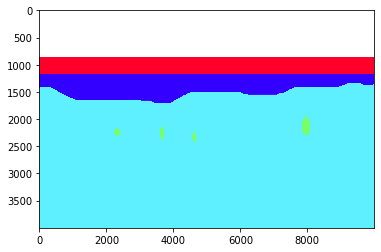

In [4]:
file="drawn/drawn.png"
data=cv2.imread(file)
plt.imshow(data,aspect='auto')

The resulting array has 3 dimensions since it comes from R,G,B

In [5]:
data.shape

(4000, 10000, 3)

### For our purposes, a greyscale is enough

Taken from: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
It should look like the matlab version

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [21]:
%matplotlib qt
data_grey=rgb2gray(data)
plt.imshow(data_grey,aspect='auto',cmap='gray',vmin=0,vmax=200)

In [17]:
np.unique(data_grey)

array([ 44.3139,  64.081 ,  67.9227,  74.3913,  81.0075, 110.8069,
       136.0911, 148.1624, 160.1905, 163.4676, 197.164 , 197.2389,
       197.9326, 254.9745])

In [38]:
np.unique(np.floor(data_grey)).shape

(12,)

In [18]:
sum_data=data[:,:,0]+data[:,:,1]+data[:,:,2]

In [19]:
np.unique(sum_data).shape

(13,)

In [26]:
n=plt.hist(data_grey.flatten(),bins=512)

In [37]:
plt.plot(n[0])

In [36]:
np.unique(n[0])

array([0.0000000e+00, 5.0000000e+00, 4.3800000e+02, 5.0600000e+02,
       6.3200000e+02, 4.1210000e+03, 5.6020000e+03, 5.9080000e+03,
       1.0000000e+04, 1.2247600e+05, 3.0400000e+06, 3.6353470e+06,
       8.6200000e+06, 2.4554965e+07])